# K Nearest Neighbors

In [44]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

First, we load the data:



In [2]:
# Dataframe

data_folder = Path(r'C:\Users\fleig\OneDrive\Copenhagen\FinalProject\Latest-News-Classifier-master\03. Feature Engineering\Pickles')

path_df = data_folder/'df.pickle'
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = data_folder/"features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = data_folder/"labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = data_folder/"features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = data_folder/"labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [3]:
print(features_train.shape)
print(features_test.shape)

(15352, 22)
(6580, 22)


## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [4]:
knnc_0 =KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knnc_0.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


We'll tune the following ones:

* `K`: Number of neighbors to use by default for queries.

In this case, since there is only one hyperparameter, we'll perform an exhaustive search directly:

### Grid Search Cross Validation

We first need to define the grid:

In [5]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 34.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46,
                                         51, 56, 61, 66, 71, 76, 81, 86, 91, 96,
                                         101, 106, 111, 116, 121, 127, 132, 137,
                                         142, 147, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

The best parameters turn out to be:

In [22]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 9}

The mean accuracy of a model with these hyperparameters is:
0.5672653114926649


Since the grid had a space of 5 between each element, we'll now cover all the possible `n_neighbors` near to 6:

In [23]:
n_neighbors = [1,2,3,4,5,6,7,8,9,10,11]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  2.1min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

The best parameters turn out to be:

In [24]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 9}

The mean accuracy of a model with these hyperparameters is:
0.5672653114926649


Let's save the model in `best_knnc`:

In [25]:
best_knnc = grid_search.best_estimator_

In [26]:
best_knnc

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

We now know the best KNN model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [27]:
best_knnc.fit(features_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

And get the predictions:

In [40]:
knnc_pred = best_knnc.predict(features_test)

# Predicts probabilities for test data
probs = best_knnc.predict_proba(features_test)

In [41]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig('ROC_knnc.png')
    plt.show()

In [42]:
# Keep probabilities of the positive class only
probs = probs[:,1]

In [45]:
# Compute AUC score
auc = roc_auc_score(labels_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.59


In [46]:
# Get the ROC curve
fpr, tpr, thresholds = roc_curve(labels_test, probs)

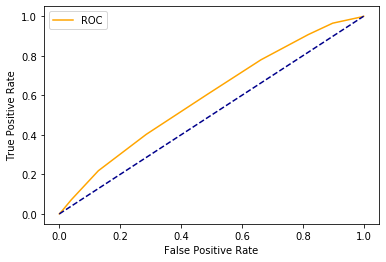

In [47]:
# Plot ROC curve using defined function
plot_roc_curve(fpr, tpr)

The conditional class probabilities can be obtained by typing:

`knnc_pred = best_knnc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [29]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train)))

The training accuracy is: 
0.6637571651902032


#### Test accuracy

In [31]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred))

The test accuracy is: 
0.5609422492401216


#### Classification report

In [32]:
# Classification report
print("Classification report")
print(classification_report(labels_test,knnc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.55      0.51      0.53      3164
           1       0.57      0.61      0.59      3416

    accuracy                           0.56      6580
   macro avg       0.56      0.56      0.56      6580
weighted avg       0.56      0.56      0.56      6580



#### Confusion matrix

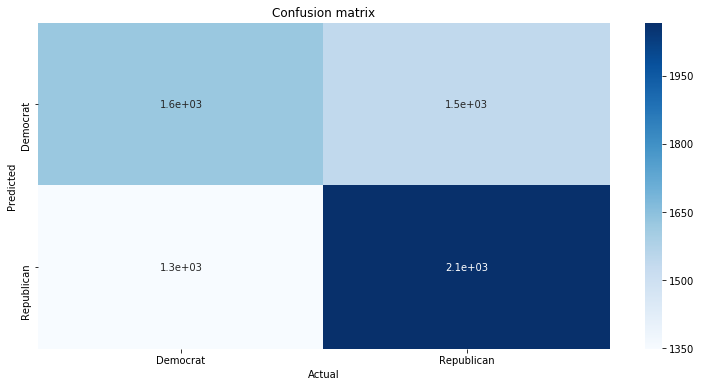

In [33]:
aux_df = df[['Party', 'Republican']].drop_duplicates().sort_values('Republican')
conf_matrix = confusion_matrix(labels_test, knnc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Party'].values, 
            yticklabels=aux_df['Party'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [34]:
base_model = KNeighborsClassifier()
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.5610942249240122

In [35]:
best_knnc.fit(features_train, labels_train)
accuracy_score(labels_test, best_knnc.predict(features_test))

0.5609422492401216

We can see that the default model (with 5 Nearest Neighbors) performs better. However, in our Grid Search Cross Validation process we tried with that number of neighbors. The reason why we may be getting this result is because de Grid Search performs a Cross Validation scheme, while this last comparison uses all training data.

We'll create a dataset with a model summary to compare models:

In [36]:
d = {
     'Model': 'KNN',
     'Training Set Accuracy': accuracy_score(labels_train, best_knnc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, knnc_pred)
}

df_models_knnc = pd.DataFrame(d, index=[0])

In [37]:
df_models_knnc

,Model,Training Set Accuracy,Test Set Accuracy
0,KNN,0.663757,0.560942


Let's save the model and this dataset:

In [38]:
with open('Models/best_knnc.pickle', 'wb') as output:
    pickle.dump(best_knnc, output)

with open('Models/df_models_knnc.pickle', 'wb') as output:
    pickle.dump(df_models_knnc, output)